# Transfer learning & fine-tuning

Author: fchollet

Date created: 2020/04/15


Last modified: 2020/05/12


Description: Complete guide to transfer learning & fine-tuning in Keras.

# Setup

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Introduction

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:


1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.


A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

First, we will go over the Keras trainable API in detail, which underlies most transfer learning & fine-tuning workflows.

Then, we'll demonstrate the typical workflow by taking a model pretrained on the ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification dataset.

# Freezing layers: understanding the trainable attribute

Layers & models have three weight attributes:

## Example: the Dense layer has 2 trainable weights (kernel & bias)

In [4]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

In [5]:
print("weights:", len(layer.weights))

weights: 2


In [6]:
print("trainable_weights:", len(layer.trainable_weights))

trainable_weights: 2


In [7]:
print("non_trainable_weights:", len(layer.non_trainable_weights))

non_trainable_weights: 0


## Example: the BatchNormalization layer has 2 trainable weights and 2 non-trainable weights

In [8]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

In [9]:
print("weights:", len(layer.weights))

weights: 4


In [10]:
print("trainable_weights:", len(layer.trainable_weights))

trainable_weights: 2


In [11]:
print("non_trainable_weights:", len(layer.non_trainable_weights))

non_trainable_weights: 2


## Example: setting trainable to False

In [12]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

In [13]:
print("weights:", len(layer.weights))

weights: 2


In [14]:
print("trainable_weights:", len(layer.trainable_weights))

trainable_weights: 0


In [15]:
print("non_trainable_weights:", len(layer.non_trainable_weights))

non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [16]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

In [19]:
layer1.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.18839383, -0.00608897, -0.67154384],
        [-0.09069014, -0.7284949 ,  0.5099106 ],
        [-0.56717324,  0.36766124,  0.68579936]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [20]:
layer2.weights

[<tf.Variable 'dense_3/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.76214385,  0.283103  , -0.3566742 ],
        [ 0.38577962,  0.50884223,  0.75268865],
        [ 0.0420785 ,  0.04899955,  0.68056273]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [17]:
# Freeze the first layer
layer1.trainable = False

In [21]:
print("trainable_weights:", len(layer1.trainable_weights))

trainable_weights: 0


In [18]:
# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()


In [22]:
# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 4ms/step - loss: 0.0258


In [26]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

## Recursive setting of the trainable attribute

If you set trainable = False on a model or on any layer that has sublayers, all children layers become non-trainable as well.

## Example:

In [27]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

In [28]:
model.trainable = False  # Freeze the outer model

In [29]:
assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

In [30]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 221s 3us/step


**Then, freeze the base model.**

In [32]:
base_model.trainable = False

**Create a new model on top.**

In [33]:
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

**Train the model on new data.**

In [34]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

NameError: name 'new_dataset' is not defined

## Fine-tuning

In [35]:
# Unfreeze the base model
base_model.trainable = True

In [37]:
#It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])


In [38]:
# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

NameError: name 'new_dataset' is not defined

 **Important note about compile() and trainable**

Calling compile() on a model is meant to "freeze" the behavior of that model. This implies that the trainable attribute values at the time the model is compiled should be preserved throughout the lifetime of that model, until compile is called again. Hence, if you change any trainable value, make sure to call compile() again on your model for your changes to be taken into account.

**Important notes about BatchNormalization layer**

## Transfer learning & fine-tuning with a custom training loop

If instead of fit(), you are using your own low-level training loop, the workflow stays essentially the same. You should be careful to only take into account the list model.trainable_weights when applying gradient updates:

In [40]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

In [41]:
# Freeze base model
base_model.trainable = False


In [42]:
# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

In [43]:
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [44]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

In [45]:
# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

NameError: name 'new_dataset' is not defined

In [46]:
# Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

IndentationError: unexpected indent (<ipython-input-46-7bf5fe1b1d1d>, line 2)

# An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer learning & fine-tuning example. We will load the Xception model, pre-trained on ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

## Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset, you'll probably want to use the utility tf.keras.preprocessing.image_dataset_from_directory to generate similar labeled dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [50]:
pip install tensorflow-datasets

  Created wheel for promise: filename=promise-2.3-cp37-none-any.whl size=21500 sha256=4ff6e217a58362bed349c1065e79d3b4cb6a5ffcc0d2646f80a6b1dc5cb3c19d
  Stored in directory: C:\Users\Hp\AppData\Local\pip\Cache\wheels\19\49\34\c3c1e78bcb954c49e5ec0d31784fe63d14d427f316b12fbde9
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


ERROR: tensorflow-metadata 0.25.0 has requirement absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.


In [51]:
import tensorflow_datasets as tfds

In [52]:
tfds.disable_progress_bar()

In [53]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

Shuffling and writing examples to C:\/Users/Hp/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete78YHXD/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to C:\Users\Hp\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


In [54]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))

Number of training samples: 9305


In [55]:
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)

Number of validation samples: 2326


In [56]:
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of test samples: 2326


In [59]:
import matplotlib.pyplot as plt

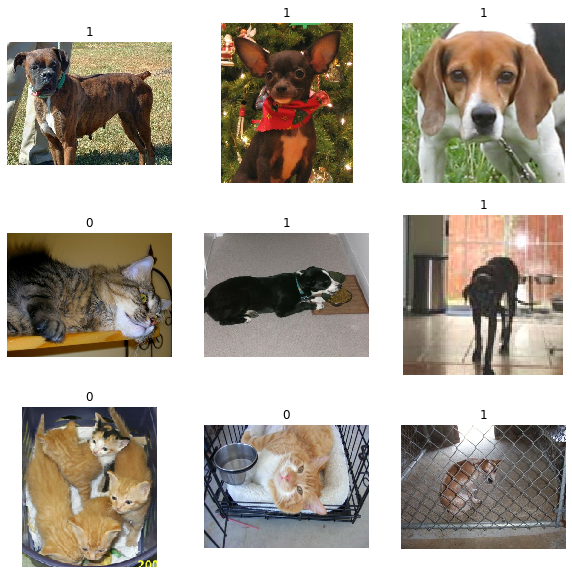

In [60]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## Standardizing the data

In [61]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [63]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

## Using random data augmentation

In [64]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

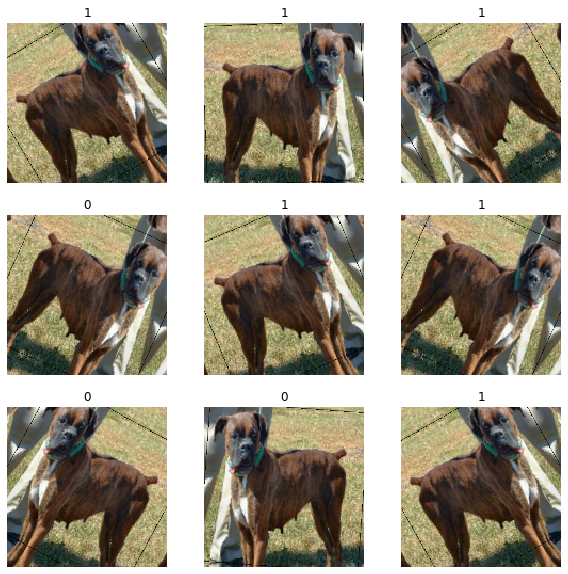

In [65]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Build a model

In [66]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

In [67]:
# Freeze the base_model
base_model.trainable = False

In [68]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

In [69]:

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])


In [70]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [71]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

## Train the top layer

In [73]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
157/291 [===============>..............] - ETA: 0s - loss: 0.2569 - binary_accuracy: 0.875 - ETA: 7:00 - loss: 0.2694 - binary_accuracy: 0.875 - ETA: 9:05 - loss: 0.1939 - binary_accuracy: 0.916 - ETA: 10:10 - loss: 0.1637 - binary_accuracy: 0.92 - ETA: 10:40 - loss: 0.1627 - binary_accuracy: 0.92 - ETA: 10:57 - loss: 0.1705 - binary_accuracy: 0.92 - ETA: 11:14 - loss: 0.1732 - binary_accuracy: 0.92 - ETA: 11:22 - loss: 0.1723 - binary_accuracy: 0.92 - ETA: 11:30 - loss: 0.1868 - binary_accuracy: 0.91 - ETA: 11:35 - loss: 0.1846 - binary_accuracy: 0.91 - ETA: 11:39 - loss: 0.1740 - binary_accuracy: 0.92 - ETA: 11:43 - loss: 0.1675 - binary_accuracy: 0.92 - ETA: 11:53 - loss: 0.1614 - binary_accuracy: 0.93 - ETA: 11:57 - loss: 0.1561 - binary_accuracy: 0.93 - ETA: 11:57 - loss: 0.1524 - binary_accuracy: 0.93 - ETA: 12:00 - loss: 0.1515 - binary_accuracy: 0.93 - ETA: 12:03 - loss: 0.1446 - binary_accuracy: 0.93 - ETA: 12:03 - loss: 0.1404 - binary_accuracy: 0.94 - ETA: 12:04 -

## Do a round of fine-tuning of the entire model

In [74]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                